## Spatial distribution of reflectivity, vertical velocity

In [1]:
from scipy import ndimage, interpolate
import pyart
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import glob
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [2]:
def area_anal(pixel_area, rr_x, rain_rates): 
    A_rainrate = np.zeros(rr_x.shape) 
    N_rainrate = np.zeros(rr_x.shape) 
    Rm_rainrate = np.zeros(rr_x.shape) 
    for i in range(len(rr_x)): 
        b_fld = np.zeros(rain_rates.shape) 
        b_fld[rain_rates > rr_x[i]] = 1.0 
        regions, N_rainrate[i] = ndimage.label(b_fld) 
        try: 
            A_rainrate[i] = (len(np.where( regions > 0.5)[0]) * pixel_area) 
            Rm_rainrate[i] = rain_rates[ np.where(regions > 0.5)].mean() 
        except IndexError: 
            A_rainrate[i] = 0.0 
            Rm_rainrate[i] = 0.0 
    return N_rainrate, A_rainrate, Rm_rainrate

In [196]:
data_path = 'C:/Users/rjackson/Documents/data/multidop_grids/'
wrf_file = 'C:/Users/rjackson/Documents/data/wrftestdata/wrfout_d01_2006-01-20_000000'
conv_strat_path = 'C:/Users/rjackson/Documents/data/conv_stratiform/'
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

def get_conv_strat(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (conv_strat_path +
                     'cpol_conv_strat' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = Dataset(file_name_str)
    return radar

# Get a Radar object given a time period in the CPOL dataset
def convert_wrf_to_grid(wrf_dataset, time_step):    
    # The pregridded files are not loadable using read_grid, 
    # so load in the necessary fields and make the Grid object out of them
    FillValue = -32768
    Z_wrf1 = wrf_dataset.variables['REFL_10CM'][time_step]
    Lat_wrf = wrf_dataset.variables['XLAT'][time_step]
    Lon_wrf = wrf_dataset.variables['XLONG'][time_step]
    W_wrf = wrf_dataset.variables['W'][time_step]
    PH_wrf = wrf_dataset.variables['PH'][time_step]
    PHB_wrf = wrf_dataset.variables['PHB'][time_step]
    time_str = wrf_dataset.variables['Times'][time_step]
    year_str = time_str[0] + time_str[1] + time_str[2] + time_str[3]
    month_str = time_str[5] + time_str[6]
    day_str = time_str[8] + time_str[9]
    hour_str = time_str[11] + time_str[12]
    minute_str = time_str[14] + time_str[15]
    second_str = time_str[17] + time_str[18]
    print('Step 1')
    alt_wrf = np.zeros(PH_wrf.shape)
    array_shape = PH_wrf.shape
    alt_wrf = (PH_wrf+PHB_wrf)/9.81
    #Z_wrf = -32768*np.ones(alt_wrf.shape)
    Z_wrf = Z_wrf1
    # Add grid locations
    
    
    H_mean = np.zeros(array_shape[0])
    for i in range(0, array_shape[0]-1):
        H_mean[i] = np.nanmean(alt_wrf[i,:,:])
    grid_x = {'data': np.arange(-array_shape[2]/2,array_shape[2]/2,1)*1e3}
    grid_y = {'data': np.arange(-array_shape[2]/2,array_shape[1]/2,1)*1e3}
    levs = {'data': H_mean}    
    
    print('Step 2')    
    
        
    # Place into dictionary
    W_wrf = {'data': W_wrf,
             'long_name': 'updraft_velocity',
             'units': 'm/s',
             '_FillValue': FillValue}
    
    Z_wrf = {'data': Z_wrf,
             'long_name': 'reflectivity',
             'units': 'dBZ',
             '_FillValue': FillValue}
    
    # Lat, lon same everywhere
    cpol_location = [Lat_wrf[1,1], Lon_wrf[1,1]]
    print(cpol_location)
         
    # Add grid fields
    cpol_grid_fields = {'W': W_wrf,
                        'Z': Z_wrf}
    
    metadata = {}
    
    
    # Add latitude and longitude entries for each radar
    origin_latitude = {'data': [cpol_location[0]],
                       'units': 'degrees'}
    origin_longitude = {'data': [cpol_location[1]],
                        'units': 'degrees'}
    cpol_latitude = {'data': [cpol_location[0]],
                       'units': 'degrees'}
    cpol_longitude = {'data': [cpol_location[1]],
                        'units': 'degrees'}
    origin_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_name = {'data': 'W'} 
    time_dict = {'units': ('seconds since ' + 
                           year_str + 
                           '-' + 
                           month_str + 
                           '-' + 
                           day_str + 
                           'T' + 
                           hour_str + 
                           ':' + 
                           minute_str + 
                           ':' +
                           second_str + 'Z'), 
                 'long_name': 'Time of grid', 'standard_name': 
                 'time', 'data': np.array([0.], dtype=float), 
                 'calendar': 'gregorian'}
    print(time_dict['units'])
    print('Step 3')
    # Create grid objects
    grid_wrf = pyart.core.Grid(time_dict, 
                               cpol_grid_fields,
                               metadata,
                               origin_latitude,
                               origin_longitude,
                               origin_altitude,
                               grid_x, 
                               grid_y,
                               levs, 
                               radar_latitude=cpol_latitude,
                               radar_longitude=cpol_longitude,
                               radar_altitude=cpol_altitude,
                               radar_name=cpol_name,
                               radar_time=time_dict)
    return grid_wrf

In [4]:
times = get_dda_times(2006, 1, 20, 0, 1,
                      2006, 1, 20, 3, 2)

We are about to load grid files for 1 days
Looking for files with format C:/Users/rjackson/Documents/data/multidop_grids/cf_compliant_grid20060120*.nc


In [94]:
reflectivity_bins = np.arange(0,60,5)
w_bins = np.arange(-50,50,0.5)

N_ref = np.zeros((len(times),len(reflectivity_bins)))
A_ref = np.zeros((len(times),len(reflectivity_bins)))
Z_ref = np.zeros((len(times),len(reflectivity_bins)))
Mean_ref = np.zeros(len(times))

N_w = np.zeros((len(times),len(w_bins)))
A_w = np.zeros((len(times),len(w_bins)))
Z_w = np.zeros((len(times),len(w_bins)))
Mean_w = np.zeros(len(times))

N_refwrf = np.zeros((len(times),len(reflectivity_bins)))
A_refwrf = np.zeros((len(times),len(reflectivity_bins)))
Z_refwrf = np.zeros((len(times),len(reflectivity_bins)))
Mean_refwrf = np.zeros(len(times))

N_wwrf = np.zeros((len(times),len(w_bins)))
A_wwrf = np.zeros((len(times),len(w_bins)))
Z_wwrf = np.zeros((len(times),len(w_bins)))
wrf_radars = []

Mean_wwrf = np.zeros(len(times))
w_level = 30
w_level_wrf = 73
i = 0
wrf_cdf = Dataset(wrf_file, mode='r')
Z_wrf = wrf_cdf.variables['REFL_10CM'][:,:,:,:]
Lat_wrf = wrf_cdf.variables['XLAT'][:,:,:]
Lon_wrf = wrf_cdf.variables['XLONG'][:,:,:]
W_wrf = wrf_cdf.variables['W'][:]
PH_wrf = wrf_cdf.variables['PH'][:]
PHB_wrf = wrf_cdf.variables['PHB'][:]
ETA_wrf = wrf_cdf.variables['ZNW'][:]
alt_wrf = np.zeros(PH_wrf.shape)
P_wrf = wrf_cdf.variables['PB'][:]
# Calculate height from WRF
array_shape = PH_wrf.shape
alt_wrf = (PH_wrf+PHB_wrf)/9.81
print(np.mean(alt_wrf[1,9,:,1]))
for grid_time in times:
    # Load observations
    grid_cpol = get_grid_from_dda(grid_time)
    ref = grid_cpol.fields['reflectivity']['data'][:]
    w = grid_cpol.fields['upward_air_velocity']['data'][:]
    x = grid_cpol.point_x['data'][1,:,:]
    y = grid_cpol.point_y['data'][1,:,:]
    lat_cpol = grid_cpol.point_latitude['data'][:,:,:]
    lon_cpol = grid_cpol.point_longitude['data'][:,:,:]
    z_cpol = grid_cpol.point_z['data'][:,:,:]
    
    conv_strat = get_conv_strat(grid_time)
    convective = conv_strat.variables['strat_conv'][:] 
    con_x = conv_strat.variables['Grid_X'][:]*1e3
    con_y = conv_strat.variables['Grid_Y'][:]*1e3
    con_x, con_y = np.meshgrid(con_x, con_y)

    # Interpolate convective-stratiform classification 
    # onto Multidop's grid
    convective = interpolate.griddata((con_x.flatten(),
                                       con_y.flatten()), 
                                      convective.flatten(), (x,y))

    N_ref[i,:], A_ref[i,:], Z_ref[i,:] = area_anal(1, 
                                                   reflectivity_bins, 
                                                   ref[1])
    N_w[i,:], A_w[i,:], Z_w[i,:] = area_anal(1, 
                                             w_bins, 
                                             w[w_level])
    
    N_refwrf[i,:], A_refwrf[i,:], Z_refwrf[i,:] = area_anal(1, 
                                                            reflectivity_bins, 
                                                            Z_wrf[i,9])
    N_wwrf[i,:], A_wwrf[i,:], Z_wwrf[i,:] = area_anal(1, 
                                                      w_bins, 
                                                      W_wrf[i,w_level_wrf])
    Z_wrf[Z_wrf < 0] = np.nan
    Mean_ref[i] = np.nanmean(ref[1])
    Mean_refwrf[i] = np.nanmean(Z_wrf[i,9])
    Mean_w[i] = np.nanmean(w[w_level])
    i = i + 1

#wrf_radars.append(convert_wrf_to_grid(wrf_cdf,1))

913.428


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in greater
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:78: RuntimeWarning: invalid value encountered in less


## Test WRF output

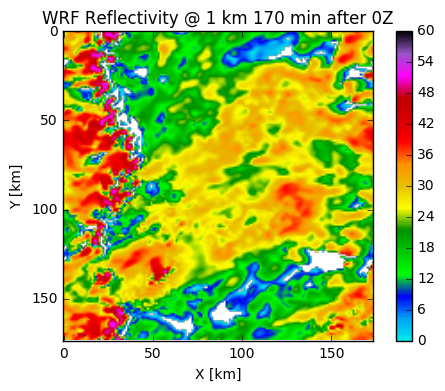

In [144]:
time_ind = 17
plt.imshow(Z_wrf[time_ind,9], cmap=pyart.graph.cm.NWSRef)
plt.colorbar()
plt.clim([0,60])
plt.title('WRF Reflectivity @ 1 km ' + str(time_ind) + '0 min after 0Z')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

Step 1
Step 2
[-12.425, 130.89101]
seconds since 2006-01-20T00:20:00Z
Step 3


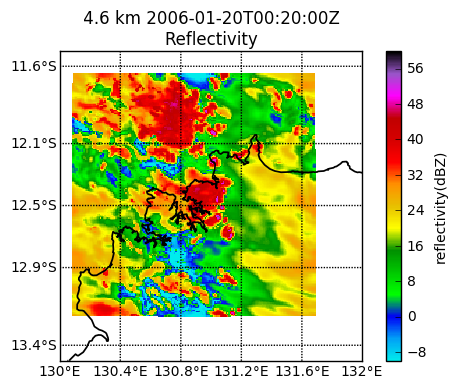

In [203]:
wrf_radar = convert_wrf_to_grid(wrf_cdf,2)
CPOLGridDisplay = pyart.graph.GridMapDisplay(wrf_radar)
CPOLGridDisplay.plot_basemap(min_lat=-13.5, max_lat=-11.5,
                             min_lon=130.0, max_lon=132.0,
                             auto_range=False,
                             lat_lines=[-11.6, -12.1, -12.5, -12.9, -13.4],
                             lon_lines=[130.0, 130.4, 130.8, 131.2, 131.6, 132.0],
                             resolution='h')
CPOLGridDisplay.plot_grid('Z', 30, vmin=-10, vmax=60,
                          cmap=pyart.graph.cm.NWSRef)

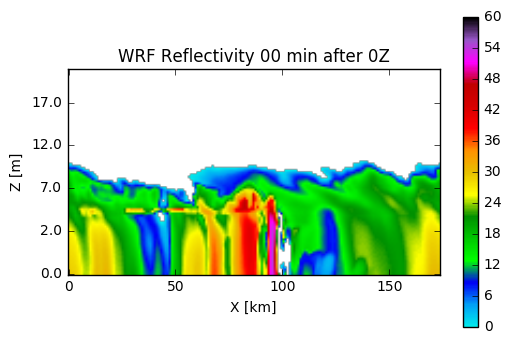

In [133]:
P_mean = np.zeros(array_shape[1])
H_mean = np.zeros(array_shape[1])
for i in range(0, array_shape[1]-1):
    P_mean[i] = np.nanmean(P_wrf[:,i,:,:])
    H_mean[i] = np.nanmean(alt_wrf[:,i,:,:])

time_ind = 0 
y_loc = 75
X,Y = np.meshgrid(np.arange(0,array_shape[3],1),H_mean)
figure = plt.figure()
axes = figure.add_subplot(111)
plt.imshow(Z_wrf[time_ind,:,y_loc,:], cmap=pyart.graph.cm.NWSRef)
plt.colorbar()
plt.clim([0,60])
plt.title('WRF Reflectivity ' + str(time_ind) + '0 min after 0Z')
plt.xlabel('X [km]')
axes.set_yticks([0,20,40,60,80])
axes.set_yticklabels([str(np.floor(H_mean[0]/1e3)),
                      str(np.floor(H_mean[20]/1e3)),
                      str(np.floor(H_mean[40]/1e3)),
                      str(np.floor(H_mean[60]/1e3)),
                      str(np.floor(H_mean[80]/1e3))])
plt.ylabel('Z [m]')
plt.gca().invert_yaxis()

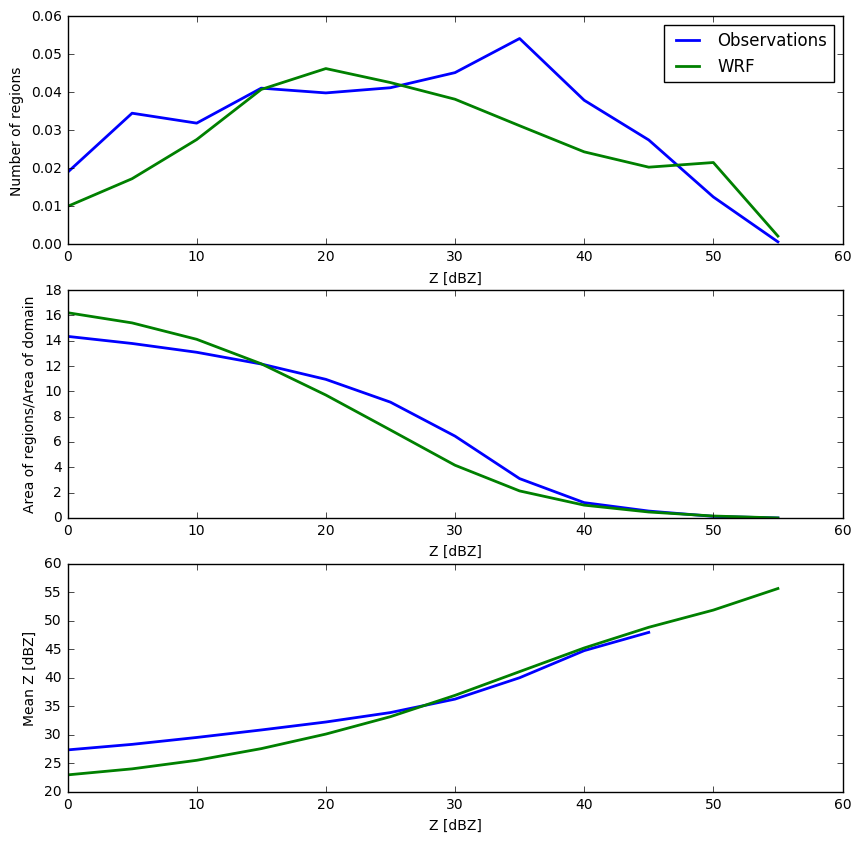

In [70]:
wrf_size=176*176
multidop_size = 80*110
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(reflectivity_bins, np.sum(N_ref,axis=0)/multidop_size, linewidth=2)
plt.plot(reflectivity_bins, np.sum(N_refwrf,axis=0)/wrf_size, linewidth=2)
plt.ylabel('Number of regions')
plt.xlabel('Z [dBZ]')
plt.legend(['Observations', 'WRF'])

plt.subplot(312)
plt.plot(reflectivity_bins, np.sum(A_ref,axis=0)/multidop_size, linewidth=2)
plt.plot(reflectivity_bins, np.sum(A_refwrf,axis=0)/wrf_size, linewidth=2)
plt.ylabel('Area of regions/Area of domain')
plt.xlabel('Z [dBZ]')

plt.subplot(313)
plt.plot(reflectivity_bins, np.mean(Z_ref,axis=0), linewidth=2)
plt.plot(reflectivity_bins, np.mean(Z_refwrf,axis=0), linewidth=2)
plt.ylabel('Mean Z [dBZ]')
plt.xlabel('Z [dBZ]')

(-10, 10)

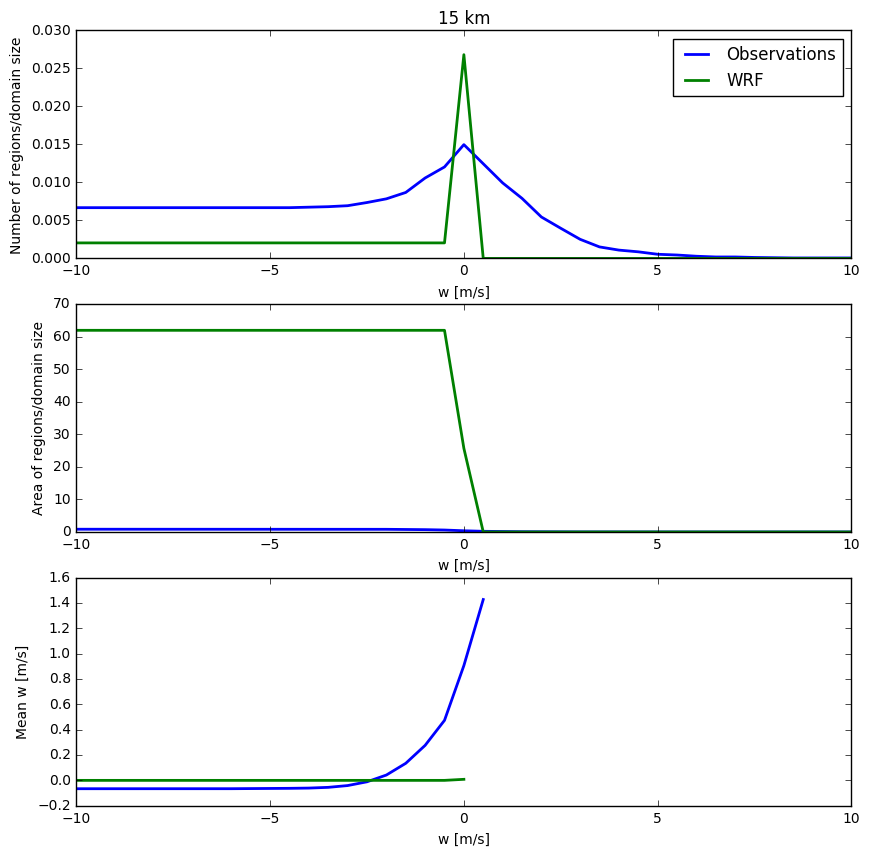

In [91]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(w_bins, np.sum(N_w,axis=0)/wrf_size, linewidth=2)
plt.plot(w_bins, np.sum(N_wwrf,axis=0)/multidop_size, linewidth=2)
plt.ylabel('Number of regions/domain size')
plt.xlabel('w [m/s]')
plt.title('15 km')
plt.xlim([-10,10])
plt.legend(['Observations', 'WRF'])

plt.subplot(312)
plt.plot(w_bins, np.sum(A_w,axis=0)/wrf_size, linewidth=2)
plt.plot(w_bins, np.sum(A_wwrf,axis=0)/multidop_size, linewidth=2)
plt.ylabel('Area of regions/domain size')
plt.xlabel('w [m/s]')
plt.xlim([-10,10])

plt.subplot(313)
plt.plot(w_bins, np.mean(Z_w,axis=0), linewidth=2)
plt.plot(w_bins, np.mean(Z_wwrf,axis=0), linewidth=2)
plt.ylabel('Mean w [m/s]')
plt.xlabel('w [m/s]')
plt.xlim([-10,10])

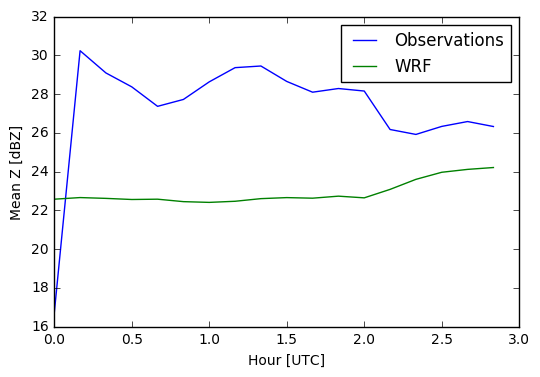

In [41]:
plt.figure()
plt.plot(np.arange(0,18,1)/6.0, Mean_ref)
plt.plot(np.arange(0,18,1)/6.0, Mean_refwrf)
plt.legend(['Observations', 'WRF'])
plt.xlabel('Hour [UTC]')
plt.ylabel('Mean Z [dBZ]')